In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats
from sklearn import preprocessing
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# restart kernel
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

In [28]:
datafile="/data0/users/bpnachman/Gaia_data/gaiamock_ra156.2_dec57.5_stream_feh-1.6_v3_951.npy"
gaiadata=np.load(datafile)
gaiadata2=np.c_[gaiadata[:,0], gaiadata[:,1], gaiadata[:,2], gaiadata[:,3], gaiadata[:,4], gaiadata[:,5]]
# gaiadata2 = np.vstack([gaiadata2[:,0].T,
#            gaiadata2[:,1].T,
#            gaiadata2[:,2].T,
#            gaiadata2[:,3].T,
#            (gaiadata2[:,5]-gaiadata2[:,6]).T,
#            gaiadata2[:,4].T]).T
print(gaiadata2)
gaiadata2 = gaiadata2[np.sum(np.isnan(gaiadata2),axis=1)==0]
center_dec=0.5*(np.max(gaiadata2[:,2])+np.min(gaiadata2[:,2]))
center_ra=0.5*(np.max(gaiadata2[:,3])+np.min(gaiadata2[:,3]))
radius=np.sqrt((gaiadata2[:,2]-center_dec)**2+(gaiadata2[:,3]-center_ra)**2)
gaiadata2=gaiadata2[radius<15]
np.random.shuffle(gaiadata2)

[[-11.          -4.83350992  56.71992712 172.46552048   0.96609879
   18.88660049]
 [  2.53341007 -26.7887001   56.7166183  172.4109408    1.4197998
   17.4946003 ]
 [ -0.442341    -0.380034    56.71930041 172.38530777   1.22979927
   17.8227005 ]
 ...
 [ -5.46443095  -1.11793992  60.0461692  180.66207152   0.76704221
   19.52924322]
 [ -7.74828417  -2.47047432  66.2224787  149.57251587   0.96668192
   18.83107588]
 [ -4.86290412  -0.75604513  61.46008779 164.38049418   0.46202579
   19.07913959]]


In [39]:
# gaiadata3=np.array(gaiadata[gaiadata['streammask']==1][['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag']].astype('float32'))
# gaiadata3 = np.vstack([gaiadata3[:,0].T,
#            gaiadata3[:,1].T,
#            gaiadata3[:,2].T,
#            gaiadata3[:,3].T,
#            (gaiadata3[:,5]-gaiadata3[:,6]).T,
#            gaiadata3[:,4].T]).T
gaiadata3 = np.c_[gaiadata[:,0], gaiadata[:,1], gaiadata[:,2], gaiadata[:,3], gaiadata[:,4], gaiadata[:,5], gaiadata[:,10]]
gaiadata3 = gaiadata3[np.where(gaiadata3[:,6] > 1)]
print(gaiadata3)
gaiadata3 = gaiadata3[np.sum(np.isnan(gaiadata3),axis=1)==0]
radius=np.sqrt((gaiadata3[:,2]-center_dec)**2+(gaiadata3[:,3]-center_ra)**2)
gaiadata3=gaiadata3[radius<15]
np.random.shuffle(gaiadata3)

[[-5.81952206e+00 -1.61105192e+00  6.53511757e+01 ...  6.52167325e-01
   1.97884000e+01  9.51000000e+02]
 [-4.73871953e+00 -1.22712757e+00  6.24398129e+01 ...  7.01136780e-01
   1.76141619e+01  9.51000000e+02]
 [-5.73705811e+00 -1.42671840e+00  6.60124815e+01 ...  6.37794185e-01
   1.86389138e+01  9.51000000e+02]
 ...
 [-5.46443095e+00 -1.11793992e+00  6.00461692e+01 ...  7.67042211e-01
   1.95292432e+01  9.51000000e+02]
 [-7.74828417e+00 -2.47047432e+00  6.62224787e+01 ...  9.66681923e-01
   1.88310759e+01  9.51000000e+02]
 [-4.86290412e+00 -7.56045126e-01  6.14600878e+01 ...  4.62025787e-01
   1.90791396e+01  9.51000000e+02]]


In [40]:
#gaiadata2_no_gd1 = np.array(gaiadata[gaiadata['streammask']==0][['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag']].astype('float32'))
# gaiadata2_no_gd1 = np.vstack([gaiadata2_no_gd1[:,0].T,
#            gaiadata2_no_gd1[:,1].T,
#            gaiadata2_no_gd1[:,2].T,
#            gaiadata2_no_gd1[:,3].T,
#            (gaiadata2_no_gd1[:,5]-gaiadata2_no_gd1[:,6]).T,
#            gaiadata2_no_gd1[:,4].T]).T
gaiadata2_no_gd1 = np.c_[gaiadata[:,0], gaiadata[:,1], gaiadata[:,2], gaiadata[:,3], gaiadata[:,4], gaiadata[:,5], gaiadata[:,10]]
gaiadata2_no_gd1 = gaiadata2_no_gd1[np.where(gaiadata2_no_gd1[:,6] < 1)]
print(gaiadata2_no_gd1)
gaiadata2_no_gd1 = gaiadata2_no_gd1[np.sum(np.isnan(gaiadata2_no_gd1),axis=1)==0]
radius=np.sqrt((gaiadata2_no_gd1[:,2]-center_dec)**2+(gaiadata2_no_gd1[:,3]-center_ra)**2)
gaiadata2_no_gd1=gaiadata2_no_gd1[radius<15]
np.random.shuffle(gaiadata2_no_gd1)                            

[[-11.          -4.83350992  56.71992712 ...   0.96609879  18.88660049
    0.        ]
 [  2.53341007 -26.7887001   56.7166183  ...   1.4197998   17.4946003
    0.        ]
 [ -0.442341    -0.380034    56.71930041 ...   1.22979927  17.8227005
    0.        ]
 ...
 [-10.47929955  -0.67713201  53.57666635 ...   1.02829933  16.64010048
    0.        ]
 [ -8.22813034   1.66313004  53.57600111 ...   0.80340004  17.9279995
    0.        ]
 [ -2.46448994  -4.40272999  53.550569   ...   0.94339943  18.93969917
    0.        ]]


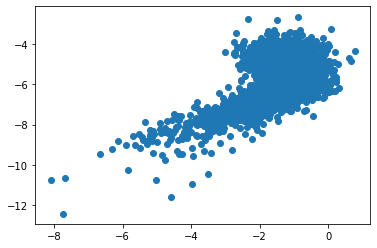

In [42]:
plt.scatter(gaiadata3[:,1],gaiadata3[:,0])

Text(0, 0.5, '$\\mu_\\delta$ [$\\mu$as/year]')

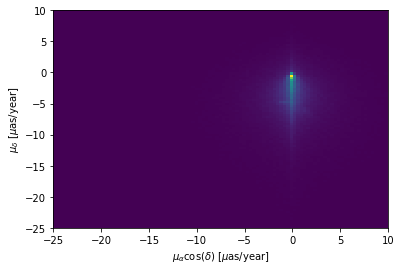

In [43]:
_,_,_,_=plt.hist2d(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),gaiadata2[:,0],bins=[np.linspace(-25,10,100),np.linspace(-25,10,100)])
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")
plt.ylabel(r"$\mu_\delta$ [$\mu$as/year]")

Text(0, 0.5, '$\\delta$ [degrees]')

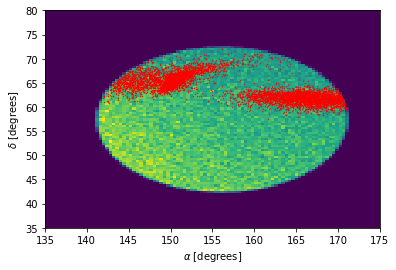

In [46]:
_,_,_,_=plt.hist2d(gaiadata2[:,3],gaiadata2[:,2], bins=[np.linspace(135,175,100),np.linspace(35,80,100)])
plt.scatter(gaiadata3[:,3],gaiadata3[:,2],color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")

Text(0.5, 0, '$\\mu_\\delta$ [$\\mu$as/year]')

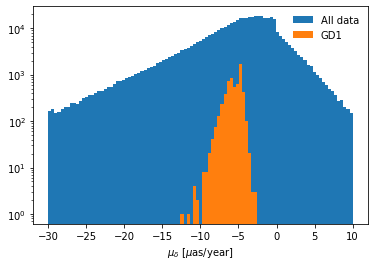

In [76]:
_,_,_=plt.hist(gaiadata2[:,0],bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,0],bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")

In [78]:
SR = gaiadata2[(gaiadata2[:,0] > -10)*(gaiadata2[:,0] < -4)]
SB = gaiadata2[(gaiadata2[:,0] > -13)*(gaiadata2[:,0] < -10)+(gaiadata2[:,0] > -4)*(gaiadata2[:,0] < -1)]
print(len(SR))
print(len(SB))
#GD1 = gaiadata3

161823
161731


In [48]:
def build_data_arrays(SR, SB, GD1, theta):
    X = SR[:,3]-center_ra
    Y = SR[:,2]-center_dec

    Xr = X*np.cos(theta) + Y*np.sin(theta)
    Yr = -X*np.sin(theta) + Y*np.cos(theta)

    Xb = SB[:,3]-center_ra
    Yb = SB[:,2]-center_dec

    Xbr = Xb*np.cos(theta) + Yb*np.sin(theta)
    Ybr = -Xb*np.sin(theta) + Yb*np.cos(theta)

    Xs = GD1[:,3]-center_ra
    Ys = GD1[:,2]-center_dec

    Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
    Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

    SR = np.c_[SR[:,0],SR[:,1],Xr, Yr, SR[:,4],SR[:,5]]
    SB = np.c_[SB[:,0],SB[:,1],Xbr, Ybr, SB[:,4],SB[:,5]]
    GD1 = np.c_[GD1[:,0],GD1[:,1],Xsr, Ysr, GD1[:,4],GD1[:,5]]
    
    return SR, SB, GD1

In [49]:
def build_model(SR, SB, GD1):
    X = np.concatenate([SR,SB,GD1])
    Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(GD1))])
    X_scaled = preprocessing.scale(X)
    GD1_scaled = X_scaled[Y==2]
    X_scaled = X_scaled[Y<2]
    Y = Y[Y<2]
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)
    
    tpr_arr = []
    fpr_arr = []
    gd1_background_x_arr = []
    gd1_background_y_arr = []

    for i in range(20):

        model = Sequential()
        model.add(Dense(64, input_dim=5, activation='relu')) 
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0) #fill out

        preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
        preds_SR = preds[Y_test == 1]

        preds_GD1 = model.predict(GD1_scaled[:,1:6], batch_size=int(0.1*len(GD1_scaled)))

        fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds_SR)),np.ones(len(preds_GD1))]), np.concatenate([preds_SR,preds_GD1]))
        fpr2, tpr2, thresholds2 = roc_curve(Y_test, preds)
        
        tpr_arr.append(tpr)
        fpr_arr.append(fpr)
        gd1_background_x_arr.append(tpr2)
        gd1_background_y_arr.append(fpr2)
    
    return tpr_arr, fpr_arr, gd1_background_x_arr, gd1_background_y_arr

# Test on data that is not rotated 

In [79]:
# SR = gaiadata2[(gaiadata2[:,0] > -15)*(gaiadata2[:,0] < -11)]
# SB = gaiadata2[(gaiadata2[:,0] > -18)*(gaiadata2[:,0] < -15)+(gaiadata2[:,0] > -11)*(gaiadata2[:,0] < -9.5)]
# GD1 = gaiadata3

SR = gaiadata2[(gaiadata2[:,0] > -10)*(gaiadata2[:,0] < -4)]
SB = gaiadata2[(gaiadata2[:,0] > -13)*(gaiadata2[:,0] < -10)+(gaiadata2[:,0] > -4)*(gaiadata2[:,0] < -1)]
GD1 = gaiadata3

SR, SB, GD1 = build_data_arrays(SR, SB, GD1, 0)

## Histograms for non-rotated data

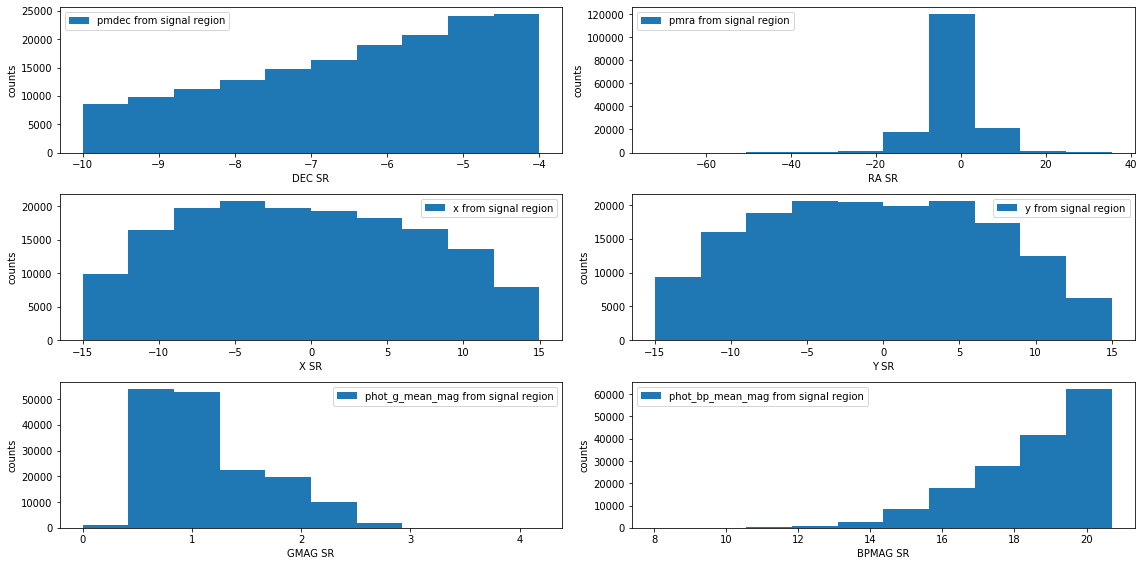

In [80]:
#SIGNAL REGION HISTOGRAMS
plt.figure(figsize = (16, 8))
plt.subplot(321)
plt.hist(SR[:, 0], label = "pmdec from signal region") 
plt.xlabel("DEC SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(322)
plt.hist(SR[:, 1], label = "pmra from signal region") 
plt.xlabel("RA SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(323)
plt.hist(SR[:, 2], label = "x from signal region")
plt.xlabel("X SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(324)
plt.hist(SR[:, 3], label = 'y from signal region')
plt.xlabel("Y SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(325)
plt.hist(SR[:, 4], label = 'phot_g_mean_mag from signal region')
plt.xlabel("GMAG SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(326)
plt.hist(SR[:, 5], label = 'phot_bp_mean_mag from signal region')
plt.xlabel("BPMAG SR")
plt.ylabel("counts")
plt.legend()

plt.tight_layout()

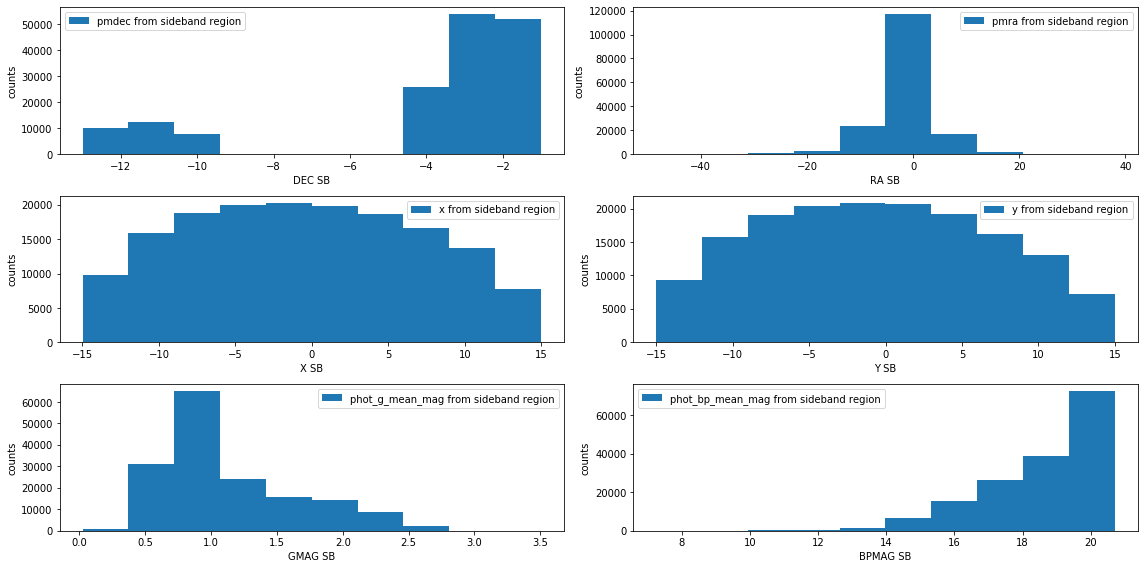

In [81]:
#SIDEBAND REGION HISTOGRAMS
plt.figure(figsize = (16, 8))
plt.subplot(321)
plt.hist(SB[:, 0], label = "pmdec from sideband region")
plt.xlabel("DEC SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(322)
plt.hist(SB[:, 1], label = "pmra from sideband region")
plt.xlabel("RA SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(323)
plt.hist(SB[:, 2], label = "x from sideband region")
plt.xlabel("X SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(324)
plt.hist(SB[:, 3], label = 'y from sideband region')
plt.xlabel("Y SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(325)
plt.hist(SB[:, 4], label = 'phot_g_mean_mag from sideband region')
plt.xlabel("GMAG SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(326)
plt.hist(SB[:, 5], label = 'phot_bp_mean_mag from sideband region')
plt.xlabel("BPMAG SB")
plt.ylabel("counts")
plt.legend()

plt.tight_layout()

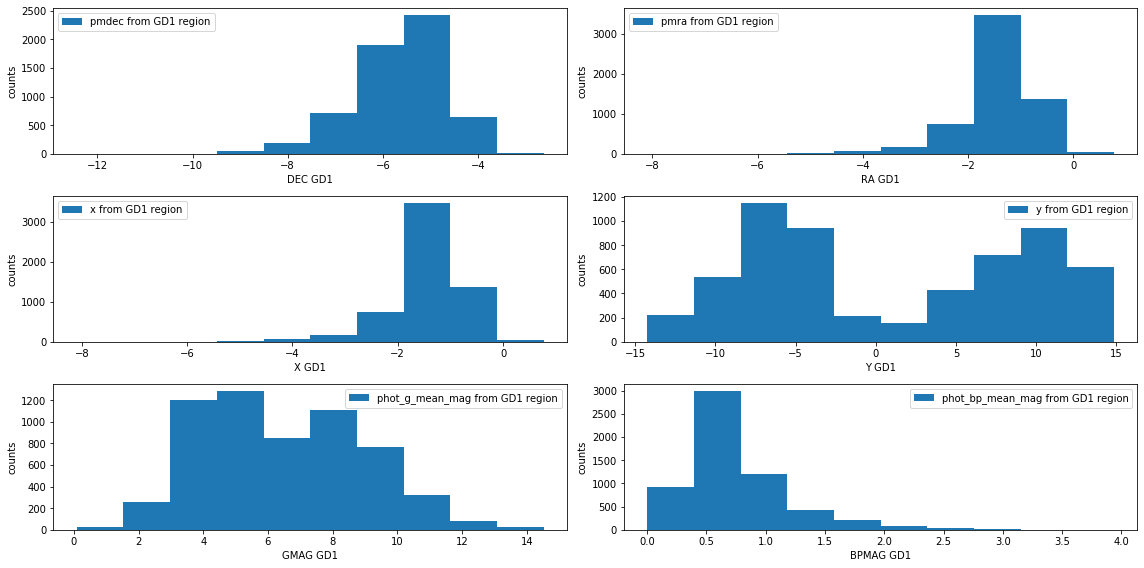

In [82]:
#OVERALL (GD1) REGION HISTOGRAMS 
plt.figure(figsize = (16, 8))
plt.subplot(321)
plt.hist(GD1[:, 0], label = "pmdec from GD1 region")
plt.xlabel("DEC GD1")
plt.ylabel("counts")
plt.legend()

plt.subplot(322)
plt.hist(GD1[:, 1], label = "pmra from GD1 region")
plt.xlabel("RA GD1")
plt.ylabel("counts")
plt.legend()

plt.subplot(323)
plt.hist(GD1[:, 1], label = "x from GD1 region")
plt.xlabel("X GD1")
plt.ylabel("counts")
plt.legend()

plt.subplot(324)
plt.hist(GD1[:, 2], label = 'y from GD1 region')
plt.xlabel("Y GD1")
plt.ylabel("counts")
plt.legend()

plt.subplot(325)
plt.hist(GD1[:, 3], label = 'phot_g_mean_mag from GD1 region')
plt.xlabel("GMAG GD1")
plt.ylabel("counts")
plt.legend()

plt.subplot(326)
plt.hist(GD1[:, 4], label = 'phot_bp_mean_mag from GD1 region')
plt.xlabel("BPMAG GD1")
plt.ylabel("counts")
plt.legend()

plt.tight_layout()

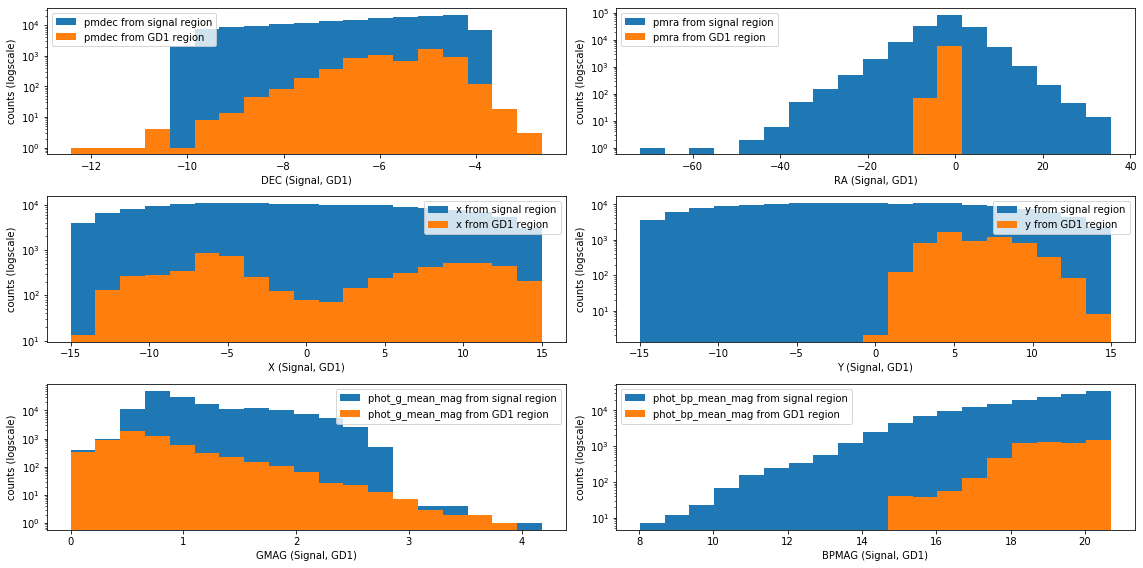

In [83]:
#OVERLAY SIGNAL AND GD1 HISTOGRAMS
plt.figure(figsize = (16, 8))
plt.subplot(321)
min_b = min(min(SR[:, 0]), min(GD1[:, 0]))
max_b = max(max(SR[:, 0]), max(GD1[:, 0]))
plt.hist(SR[:, 0], bins = np.linspace(min_b, max_b, 20), label = "pmdec from signal region") 
plt.hist(GD1[:, 0], bins = np.linspace(min_b, max_b, 20), label = "pmdec from GD1 region")
plt.xlabel("DEC (Signal, GD1)")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(322)
min_b = min(min(SR[:, 1]), min(GD1[:, 1]))
max_b = max(max(SR[:, 1]), max(GD1[:, 1]))
plt.hist(SR[:, 1], bins = np.linspace(min_b, max_b, 20), label = "pmra from signal region") 
plt.hist(GD1[:, 1], bins = np.linspace(min_b, max_b, 20), label = "pmra from GD1 region")
plt.xlabel("RA (Signal, GD1)")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(323)
min_b = min(min(SR[:, 2]), min(GD1[:, 2]))
max_b = max(max(SR[:, 2]), max(GD1[:, 2]))
plt.hist(SR[:, 2], bins = np.linspace(min_b, max_b, 20), label = "x from signal region")
plt.hist(GD1[:, 2], bins = np.linspace(min_b, max_b, 20), label = "x from GD1 region")
plt.xlabel("X (Signal, GD1)")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(324)
min_b = min(min(SR[:, 3]), min(GD1[:, 3]))
max_b = max(max(SR[:, 3]), max(GD1[:, 3]))
plt.hist(SR[:, 3], bins = np.linspace(min_b, max_b, 20), label = 'y from signal region')
plt.hist(GD1[:, 3], bins = np.linspace(min_b, max_b, 20), label = 'y from GD1 region')
plt.xlabel("Y (Signal, GD1)")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(325)
min_b = min(min(SR[:, 4]), min(GD1[:, 4]))
max_b = max(max(SR[:, 4]), max(GD1[:, 4]))
plt.hist(SR[:, 4], bins = np.linspace(min_b, max_b, 20), label = 'phot_g_mean_mag from signal region')
plt.hist(GD1[:, 4], bins = np.linspace(min_b, max_b, 20), label = 'phot_g_mean_mag from GD1 region')
plt.xlabel("GMAG (Signal, GD1)")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(326)
min_b = min(min(SR[:, 5]), min(GD1[:, 5]))
max_b = max(max(SR[:, 5]), max(GD1[:, 5]))
plt.hist(SR[:,5], bins = np.linspace(min_b, max_b, 20), label = 'phot_bp_mean_mag from signal region')
plt.hist(GD1[:,5], bins = np.linspace(min_b, max_b, 20), label = 'phot_bp_mean_mag from GD1 region')
plt.xlabel("BPMAG (Signal, GD1)")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.tight_layout()

Text(0, 0.5, 'RA GD1')

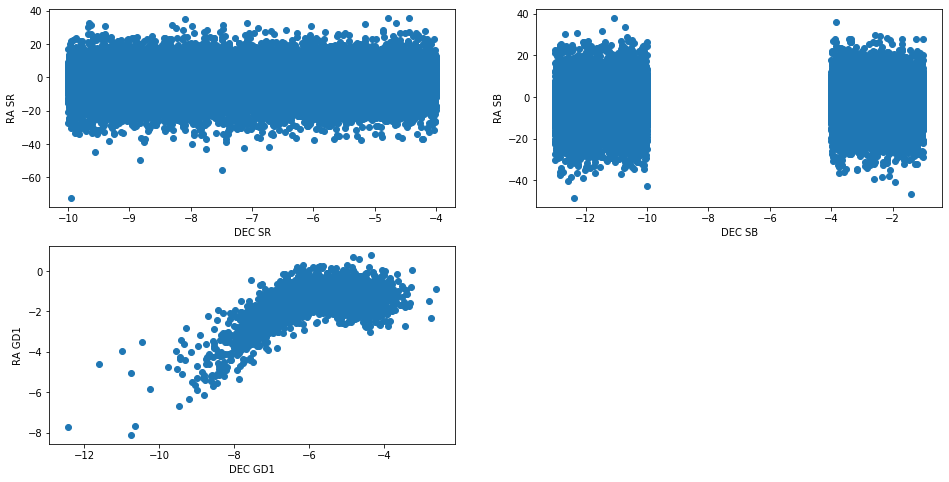

In [84]:
#PLOT DEC VS RA
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 1])
plt.xlabel("DEC SR")
plt.ylabel("RA SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 1])
plt.xlabel("DEC SB")
plt.ylabel("RA SB")

plt.subplot(223)
plt.scatter(GD1[: ,0], GD1[:, 1])
plt.xlabel("DEC GD1")
plt.ylabel("RA GD1")

Text(0, 0.5, 'X GD1')

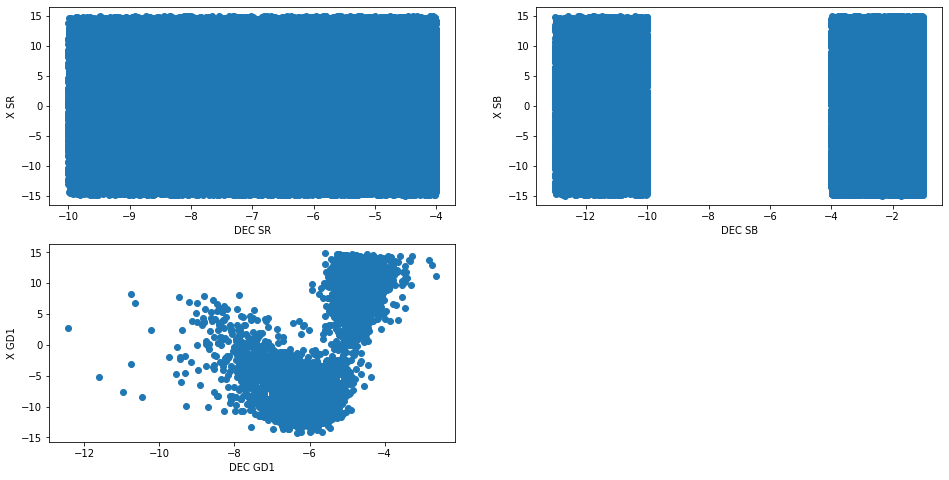

In [85]:
#PLOT DEC VS X
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 2])
plt.xlabel("DEC SR")
plt.ylabel("X SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 2])
plt.xlabel("DEC SB")
plt.ylabel("X SB")

plt.subplot(223)
plt.scatter(GD1[: ,0], GD1[:, 2])
plt.xlabel("DEC GD1")
plt.ylabel("X GD1")

Text(0, 0.5, 'Y GD1')

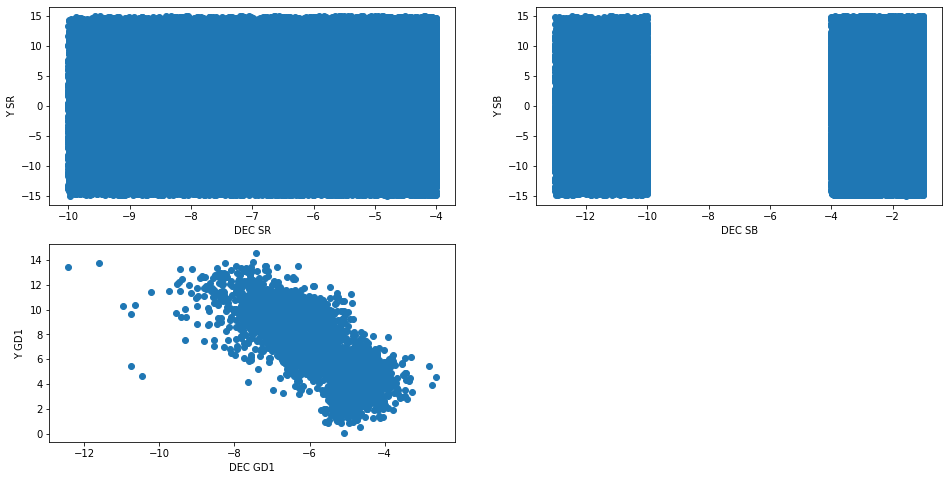

In [86]:
#PLOT DEC VS Y
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 3])
plt.xlabel("DEC SR")
plt.ylabel("Y SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 3])
plt.xlabel("DEC SB")
plt.ylabel("Y SB")

plt.subplot(223)
plt.scatter(GD1[: ,0], GD1[:, 3])
plt.xlabel("DEC GD1")
plt.ylabel("Y GD1")

Text(0, 0.5, 'GMAG GD1')

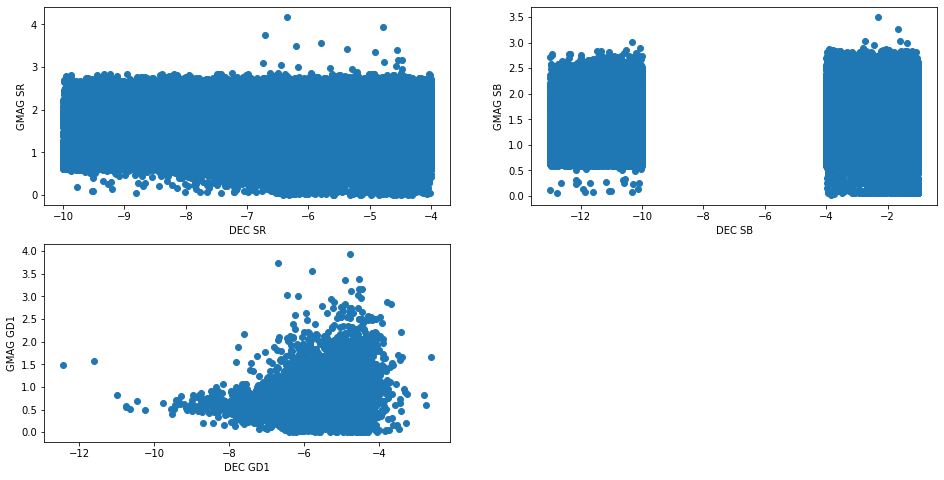

In [87]:
#PLOT DEC VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 4])
plt.xlabel("DEC SR")
plt.ylabel("GMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 4])
plt.xlabel("DEC SB")
plt.ylabel("GMAG SB")

plt.subplot(223)
plt.scatter(GD1[: ,0], GD1[:, 4])
plt.xlabel("DEC GD1")
plt.ylabel("GMAG GD1")

Text(0, 0.5, 'BPMAG GD1')

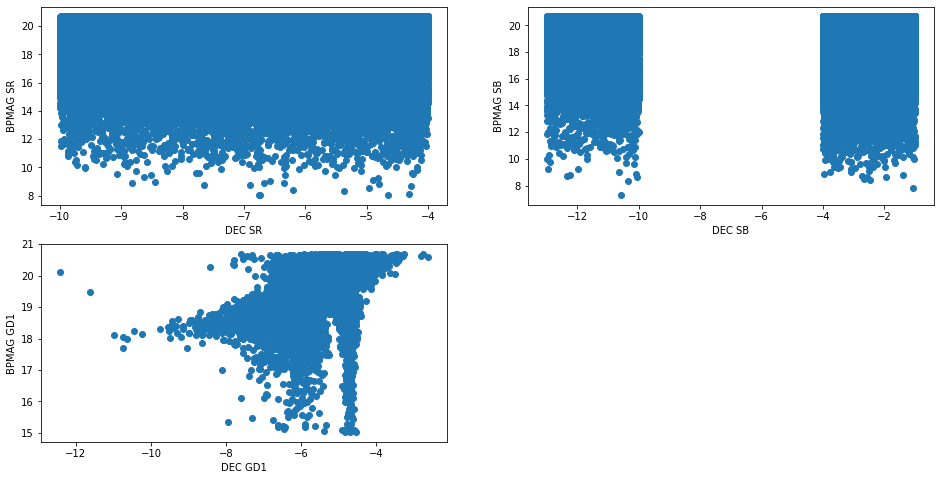

In [88]:
#PLOT DEC VS BPMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 5])
plt.xlabel("DEC SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 5])
plt.xlabel("DEC SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(GD1[: ,0], GD1[:, 5])
plt.xlabel("DEC GD1")
plt.ylabel("BPMAG GD1")

Text(0, 0.5, 'X GD1')

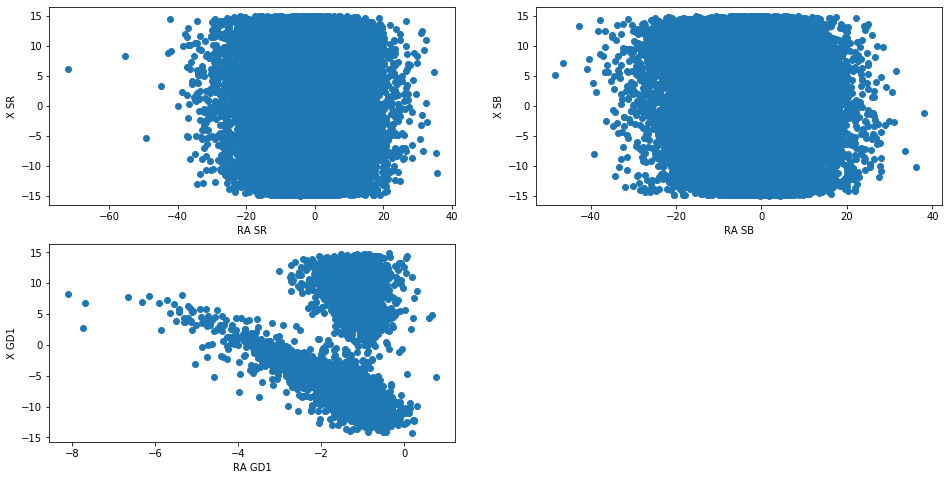

In [89]:
#PLOT RA VS X
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 1], SR[:, 2])
plt.xlabel("RA SR")
plt.ylabel("X SR")

plt.subplot(222)
plt.scatter(SB[:, 1], SB[:, 2])
plt.xlabel("RA SB")
plt.ylabel("X SB")

plt.subplot(223)
plt.scatter(GD1[: ,1], GD1[:, 2])
plt.xlabel("RA GD1")
plt.ylabel("X GD1")

Text(0, 0.5, 'Y GD1')

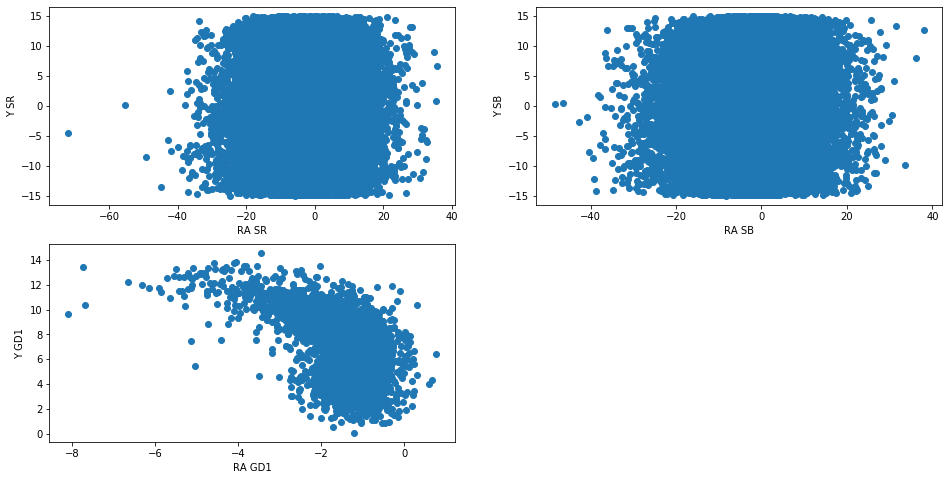

In [90]:
#PLOT RA VS Y
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 1], SR[:, 3])
plt.xlabel("RA SR")
plt.ylabel("Y SR")

plt.subplot(222)
plt.scatter(SB[:, 1], SB[:, 3])
plt.xlabel("RA SB")
plt.ylabel("Y SB")

plt.subplot(223)
plt.scatter(GD1[: ,1], GD1[:, 3])
plt.xlabel("RA GD1")
plt.ylabel("Y GD1")

Text(0, 0.5, 'GMAG GD1')

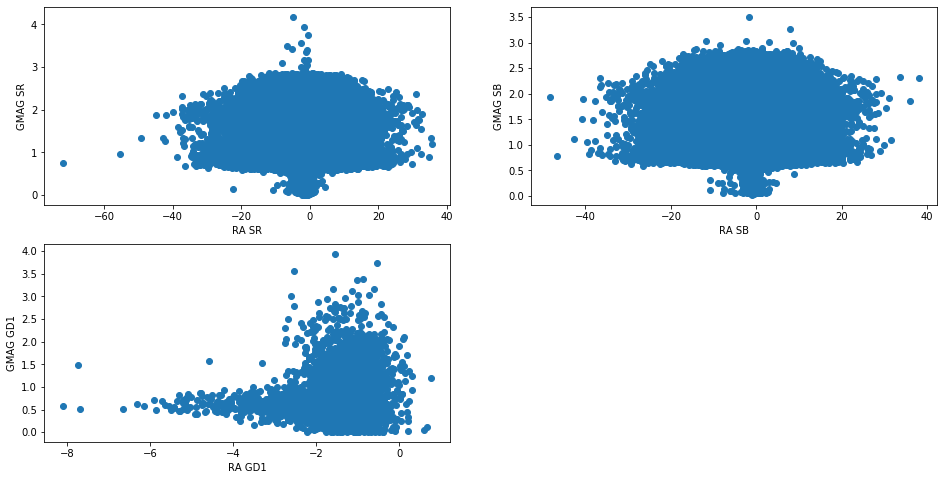

In [91]:
#PLOT RA VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 1], SR[:, 4])
plt.xlabel("RA SR")
plt.ylabel("GMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 1], SB[:, 4])
plt.xlabel("RA SB")
plt.ylabel("GMAG SB")

plt.subplot(223)
plt.scatter(GD1[: ,1], GD1[:, 4])
plt.xlabel("RA GD1")
plt.ylabel("GMAG GD1")

Text(0, 0.5, 'BPMAG GD1')

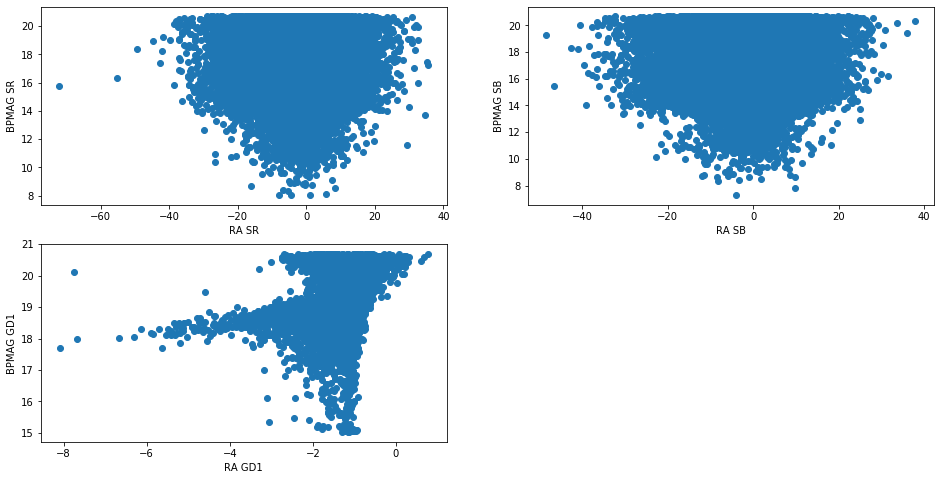

In [92]:
#PLOT RA VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 1], SR[:, 5])
plt.xlabel("RA SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 1], SB[:, 5])
plt.xlabel("RA SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(GD1[: ,1], GD1[:, 5])
plt.xlabel("RA GD1")
plt.ylabel("BPMAG GD1")

Text(0, 0.5, 'Y GD1')

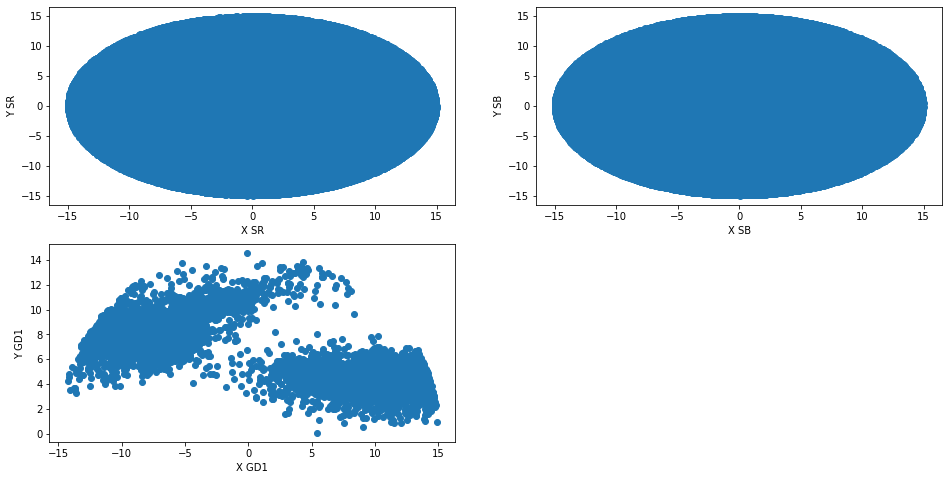

In [93]:
#PLOT X VS Y
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 2], SR[:, 3])
plt.xlabel("X SR")
plt.ylabel("Y SR")

plt.subplot(222)
plt.scatter(SB[:, 2], SB[:, 3])
plt.xlabel("X SB")
plt.ylabel("Y SB")

plt.subplot(223)
plt.scatter(GD1[:, 2], GD1[:, 3])
plt.xlabel("X GD1")
plt.ylabel("Y GD1")

Text(0, 0.5, 'GMAG GD1')

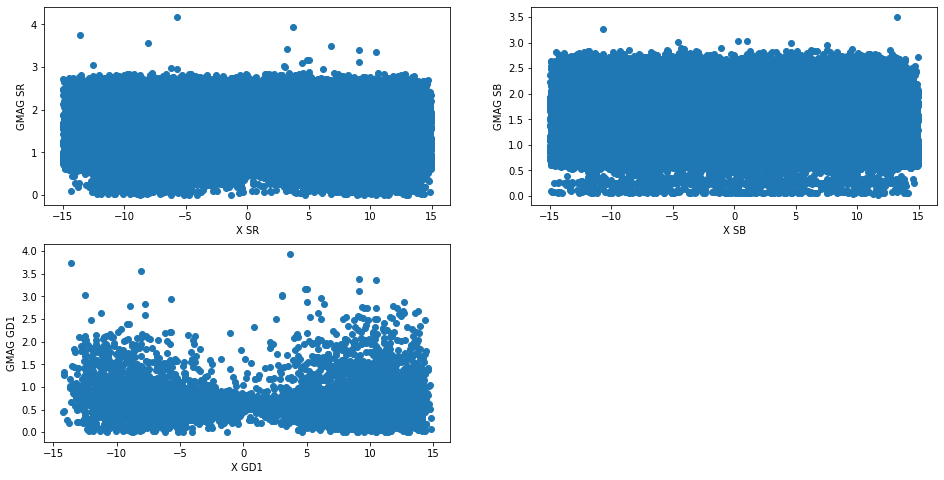

In [94]:
#PLOT X VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 2], SR[:, 4])
plt.xlabel("X SR")
plt.ylabel("GMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 2], SB[:, 4])
plt.xlabel("X SB")
plt.ylabel("GMAG SB")

plt.subplot(223)
plt.scatter(GD1[:, 2], GD1[:, 4])
plt.xlabel("X GD1")
plt.ylabel("GMAG GD1")

Text(0, 0.5, 'BPMAG GD1')

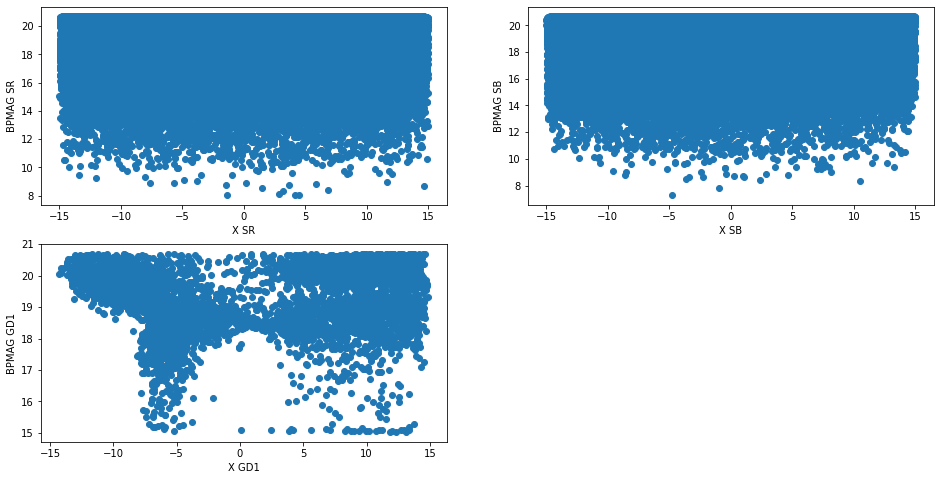

In [95]:
#PLOT X VS BPMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 2], SR[:, 5])
plt.xlabel("X SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 2], SB[:, 5])
plt.xlabel("X SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(GD1[:, 2], GD1[:, 5])
plt.xlabel("X GD1")
plt.ylabel("BPMAG GD1")

Text(0, 0.5, 'GMAG GD1')

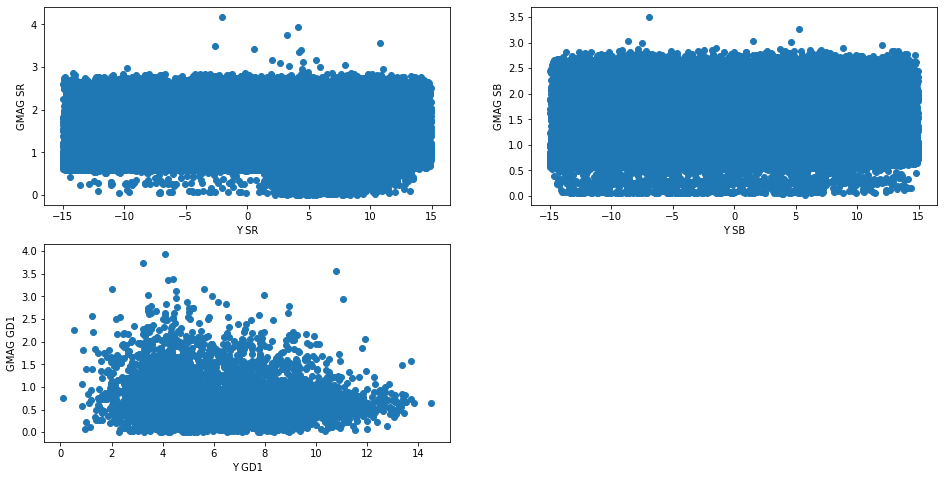

In [96]:
#PLOT Y VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 3], SR[:, 4])
plt.xlabel("Y SR")
plt.ylabel("GMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 3], SB[:, 4])
plt.xlabel("Y SB")
plt.ylabel("GMAG SB")

plt.subplot(223)
plt.scatter(GD1[:, 3], GD1[:, 4])
plt.xlabel("Y GD1")
plt.ylabel("GMAG GD1")

Text(0, 0.5, 'BPMAG GD1')

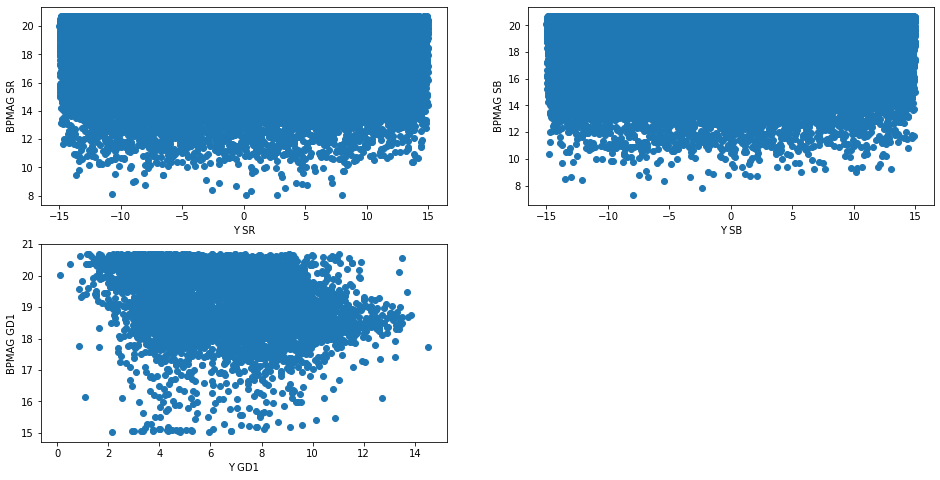

In [97]:
#PLOT Y VS BPMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 3], SR[:, 5])
plt.xlabel("Y SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 3], SB[:, 5])
plt.xlabel("Y SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(GD1[:, 3], GD1[:, 5])
plt.xlabel("Y GD1")
plt.ylabel("BPMAG GD1")

Text(0, 0.5, 'BPMAG GD1')

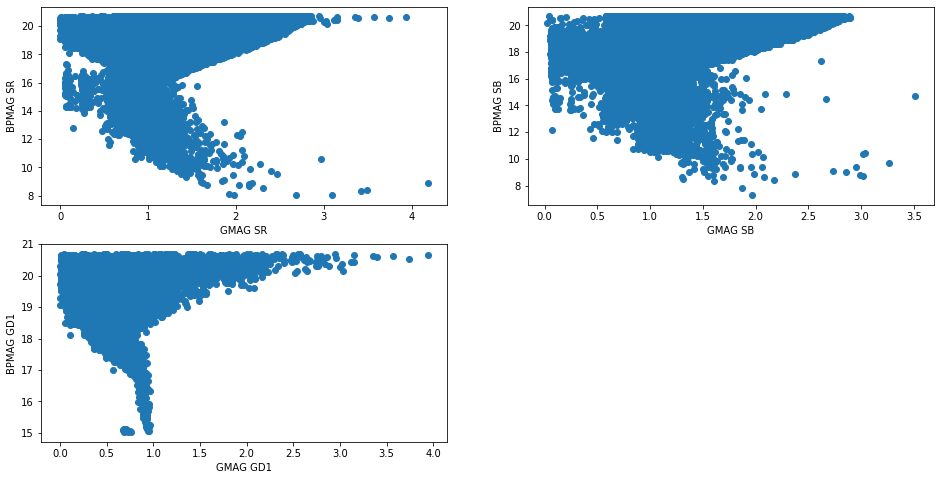

In [98]:
#PLOT GMAG VS BPMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 4], SR[:, 5])
plt.xlabel("GMAG SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 4], SB[:, 5])
plt.xlabel("GMAG SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(GD1[:, 4], GD1[:, 5])
plt.xlabel("GMAG GD1")
plt.ylabel("BPMAG GD1")

Text(0, 0.5, 'counts')

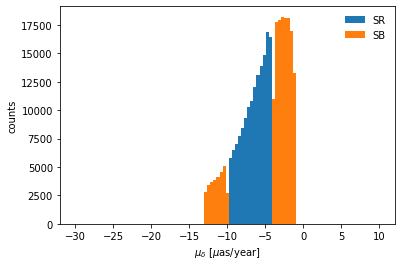

In [99]:
_,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
_,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("counts")

In [100]:
tpr_no_rot, fpr_no_rot, tpr_no_rot_gd1_background, fpr_no_rot_gd1_background = build_model(SR, SB, GD1)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


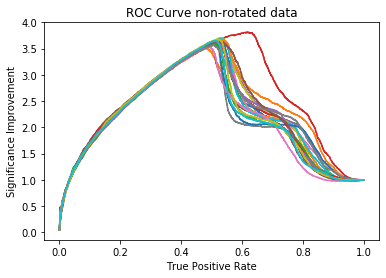

In [101]:
for x, y in zip(tpr_no_rot, fpr_no_rot):
    plt.plot(x, x/y**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.title("ROC Curve non-rotated data")
plt.show()

# Remove GD1

In [102]:
SR = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -10)*(gaiadata2_no_gd1[:,0] < -4)]
SB = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -13)*(gaiadata2_no_gd1[:,0] < -10)+(gaiadata2_no_gd1[:,0] > -4)*(gaiadata2_no_gd1[:,0] < -1)]
GD1 = gaiadata3

SR, SB, GD1 = build_data_arrays(SR, SB, GD1, 0)

In [103]:
tpr_no_gd1, fpr_no_gd1, tpr_no_gd1_gd1_background, fpr_no_gd1_gd1_background = build_model(SR, SB, GD1)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


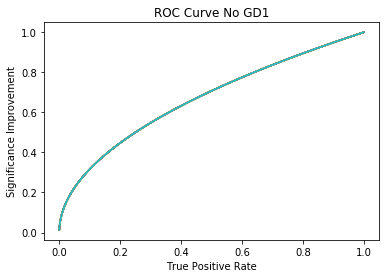

In [111]:
for x, y in zip(tpr_no_gd1, tpr_no_gd1):
    plt.plot(x, x/y**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.title("ROC Curve No GD1")
plt.show()

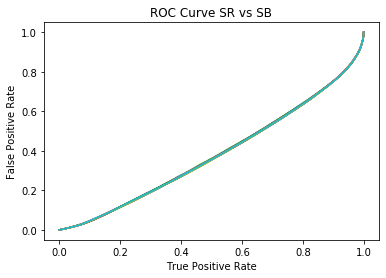

In [110]:
for x, y in zip(tpr_no_gd1_gd1_background, fpr_no_gd1_gd1_background):
    plt.plot(x, y)
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve SR vs SB")
plt.show()

## Signal and sideband without GD1, signal shifted to right

In [ ]:
### do this

In [137]:
SR = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -11) * (gaiadata2_no_gd1[:,0] < -6)]
SB = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -6)*(gaiadata2_no_gd1[:,0] < -4)+(gaiadata2_no_gd1[:,0] > -11)*(gaiadata2_no_gd1[:,0] < -9.5)]
GD1 = gaiadata3

SR, SB, GD1 = build_data_arrays(SR, SB, GD1, 0)

Text(0, 0.5, 'counts')

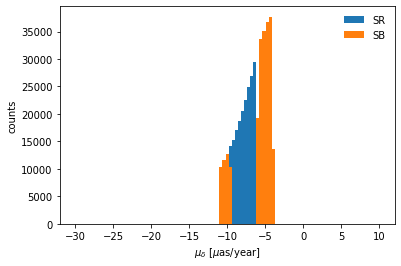

In [138]:
_,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
_,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("counts")

In [140]:
tpr_no_gd1_sr_right, fpr_no_gd1_sr_right, tpr_no_gd1_sr_right_gd1_background, fpr_no_gd1_sr_right_gd1_background = build_model(SR, SB, GD1)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


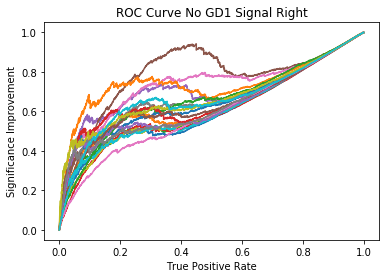

In [141]:
for x, y in zip(tpr_no_gd1_sr_right, fpr_no_gd1_sr_right):
    plt.plot(x, x/y**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.title("ROC Curve No GD1 Signal Right")
plt.show()

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


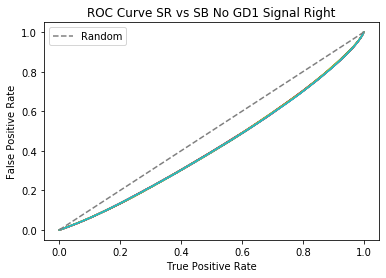

In [142]:
for x, y in zip(tpr_no_gd1_sr_right_gd1_background, fpr_no_gd1_sr_right_gd1_background):
    plt.plot(x, y)
plt.plot([0, 1], [0, 1], 'gray', ls = '--', label = 'Random')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve SR vs SB No GD1 Signal Right")
plt.show()

## Fractions of GD1

In [114]:
fractions = [250, 500, 750]
gaiadata_fractions_gd1 = [[] for x in fractions]
tpr_fractions = [[] for x in fractions]
fpr_fractions = [[] for x in fractions]
tpr_fractions_gd1_background = [[] for x in fractions]
fpr_fractions_gd1_background = [[] for x in fractions]

import random
for counter in range(len(fractions)):
    print(counter)
    gaiadata_fractions_gd1[counter] = gaiadata2_no_gd1
    
    for i in range(len(gaiadata3)):
        if random.randint(0, 1000) < fractions[counter]:
            gaiadata_fractions_gd1[counter] = np.append(gaiadata_fractions_gd1[counter], [gaiadata3[i]], 0)
    
    
    SR = gaiadata_fractions_gd1[counter][(gaiadata_fractions_gd1[counter][:,0] > -10)*(gaiadata_fractions_gd1[counter][:,0] < -4)]
    SB = gaiadata_fractions_gd1[counter][(gaiadata_fractions_gd1[counter][:,0] > -13)*(gaiadata_fractions_gd1[counter][:,0] < -10)+(gaiadata_fractions_gd1[counter][:,0] > -4)*(gaiadata_fractions_gd1[counter][:,0] < -1)]
    GD1 = gaiadata3

    SR, SB, GD1 = build_data_arrays(SR, SB, GD1, 0)

    tpr_fractions[counter], fpr_fractions[counter], tpr_fractions_gd1_background[counter], fpr_fractions_gd1_background[counter] = build_model(SR, SB, GD1)

0
1
2


In [133]:
### copy numbers
fractions = [0, 250, 500, 750]
gaiadata_fractions_gd1_2 = [[] for x in fractions]
tpr_fractions_2 = [[] for x in fractions]
fpr_fractions_2 = [[] for x in fractions]
tpr_fractions_gd1_background_2 = [[] for x in fractions]
fpr_fractions_gd1_background_2 = [[] for x in fractions]

import random
for counter in range(len(fractions)):
    print(counter)
    gaiadata_fractions_gd1_2[counter] = gaiadata2_no_gd1
    
    for i in range(len(gaiadata3)):
        if random.randint(0, 1000) < fractions[counter]:
            gaiadata_fractions_gd1_2[counter] = np.append(gaiadata_fractions_gd1_2[counter], [gaiadata3[i]], 0)
    
    
    SR = gaiadata_fractions_gd1_2[counter][(gaiadata_fractions_gd1_2[counter][:,0] > -10)*(gaiadata_fractions_gd1_2[counter][:,0] < -4)]
    SB = gaiadata_fractions_gd1_2[counter][(gaiadata_fractions_gd1_2[counter][:,0] > -13)*(gaiadata_fractions_gd1_2[counter][:,0] < -10)+(gaiadata_fractions_gd1_2[counter][:,0] > -4)*(gaiadata_fractions_gd1_2[counter][:,0] < -1)]
    GD1 = gaiadata3    
    
    print(len(SR), len(SB))

    

0
155970 161652
1
157420 161673
2
158965 161690
3
160390 161714


In [138]:
sig_improvements = gaiadata_fractions_gd1 = [[] for x in range(len(fractions)+1)]
sig_improvements[0] = [x/y**0.5 for x, y in zip(tpr_fractions[0], fpr_fractions[0])]
sig_improvements[1] = [x/y**0.5 for x, y in zip(tpr_fractions[1], fpr_fractions[1])]
sig_improvements[2] = [x/y**0.5 for x, y in zip(tpr_fractions[2], fpr_fractions[2])]
sig_improvements[3] = [x/y**0.5 for x, y in zip(tpr_no_rot, fpr_no_rot)]

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:4:

In [129]:
sig_100 = []
for x, y in zip(tpr_100, fpr_100):
    sig_100.append(x/y**0.5)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [135]:
sig_000 = []
for x, y in zip(tpr_000, fpr_000):
    sig_000.append(x/y**0.5)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Maximum significance improvement for \n20 Significance Improvement Curves vs. Fraction of GD1 included')

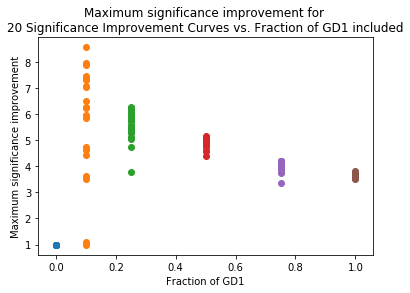

In [136]:
plt.scatter([0.0]*20, [max(y[np.isfinite(y)]) for y in sig_000])
plt.scatter([0.1]*20, [max(y[np.isfinite(y)]) for y in sig_100])
plt.scatter([0.25]*20, [max(y[np.isfinite(y)]) for y in sig_improvements[0]])
plt.scatter([0.5]*20, [max(y[np.isfinite(y)]) for y in sig_improvements[1]])
plt.scatter([0.75]*20, [max(y[np.isfinite(y)]) for y in sig_improvements[2]])
plt.scatter([1.0]*20, [max(y[np.isfinite(y)]) for y in sig_improvements[3]])
plt.xlabel("Fraction of GD1")
plt.ylabel("Maximum significance improvement")
plt.title("Maximum significance improvement for \n20 Significance Improvement Curves vs. Fraction of GD1 included")

In [ ]:
#try with fraction = 0

In [122]:
gaiadata_100_gd1 = gaiadata2_no_gd1
for i in range(len(gaiadata3)):
    if random.randint(0, 1000) < 100:
        gaiadata_100_gd1 = np.append(gaiadata_100_gd1, [gaiadata3[i]], 0)
    
    
SR = gaiadata_100_gd1[(gaiadata_100_gd1[:,0] > -10)*(gaiadata_100_gd1[:,0] < -4)]
SB = gaiadata_100_gd1[(gaiadata_100_gd1[:,0] > -13)*(gaiadata_100_gd1[:,0] < -10)+(gaiadata_100_gd1[:,0] > -4)*(gaiadata_100_gd1[:,0] < -1)]
GD1 = gaiadata3

SR, SB, GD1 = build_data_arrays(SR, SB, GD1, 0)

tpr_100, fpr_100, tpr_100_gd1_background, fpr_100_gd1_background = build_model(SR, SB, GD1)


In [134]:
gaiadata_000_gd1 = gaiadata2_no_gd1
for i in range(len(gaiadata3)):
    if random.randint(0, 1000) < 0:
        gaiadata_000_gd1 = np.append(gaiadata_000_gd1, [gaiadata3[i]], 0)
    
    
SR = gaiadata_000_gd1[(gaiadata_000_gd1[:,0] > -10)*(gaiadata_000_gd1[:,0] < -4)]
SB = gaiadata_000_gd1[(gaiadata_000_gd1[:,0] > -13)*(gaiadata_000_gd1[:,0] < -10)+(gaiadata_000_gd1[:,0] > -4)*(gaiadata_000_gd1[:,0] < -1)]
GD1 = gaiadata3

SR, SB, GD1 = build_data_arrays(SR, SB, GD1, 0)

tpr_000, fpr_000, tpr_000_gd1_background, fpr_000_gd1_background = build_model(SR, SB, GD1)



/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


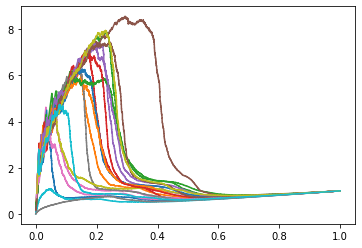

In [127]:
for x, y in zip(tpr_100, fpr_100):
    plt.plot(x, x/y**0.5)

In [124]:
print('hi')

hi


In [125]:
print('hi')

hi


In [126]:
print('hi')

hi


Text(0.5, 1.0, 'Box and whisker plots for maximum significance improvement for \n 20 Significance Improvement Curves vs. Fraction of GD1 included')

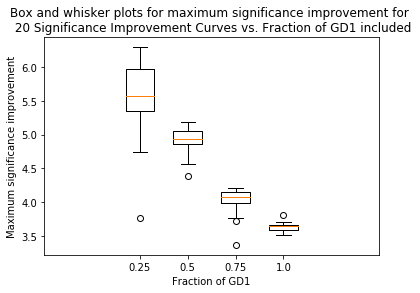

In [117]:
plt.boxplot([max(y[np.isfinite(y)]) for y in sig_improvements[0]], positions = [0.25])
plt.boxplot([max(y[np.isfinite(y)]) for y in sig_improvements[1]], positions = [0.50])
plt.boxplot([max(y[np.isfinite(y)]) for y in sig_improvements[2]], positions = [0.75])
plt.boxplot([max(y[np.isfinite(y)]) for y in sig_improvements[3]], positions = [1.00])
plt.xlabel("Fraction of GD1")
plt.ylabel("Maximum significance improvement")
plt.title("Box and whisker plots for maximum significance improvement for \n 20 Significance Improvement Curves vs. Fraction of GD1 included")

Text(0.5, 1.0, 'Mean of maximum significance improvement for \n 20 Significance Improvement Curves vs. Fraction of GD1 included')

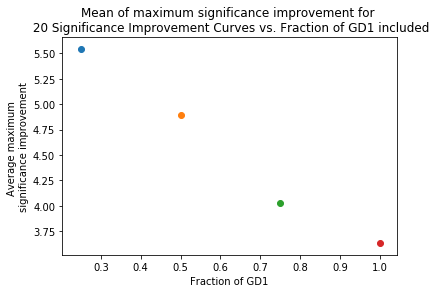

In [118]:
plt.scatter([0.25], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[0]]))
plt.scatter([0.50], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[1]]))
plt.scatter([0.75], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[2]]))
plt.scatter([1.00], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[3]]))
plt.xlabel("Fraction of GD1")
plt.ylabel("Average maximum \nsignificance improvement")
plt.title("Mean of maximum significance improvement for \n 20 Significance Improvement Curves vs. Fraction of GD1 included")